In [1]:
pip install numba --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
from distributed import Client


client = Client()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


2024-07-16 03:50:47,944 - distributed.scheduler - WARNING - Worker failed to heartbeat for 345s; attempting restart: <WorkerState 'tcp://127.0.0.1:49748', name: 2, status: running, memory: 0, processing: 0>
2024-07-16 03:50:48,073 - distributed.scheduler - WARNING - Worker failed to heartbeat for 345s; attempting restart: <WorkerState 'tcp://127.0.0.1:49751', name: 3, status: running, memory: 0, processing: 0>
2024-07-16 03:50:48,073 - distributed.scheduler - WARNING - Worker failed to heartbeat for 345s; attempting restart: <WorkerState 'tcp://127.0.0.1:49752', name: 0, status: running, memory: 0, processing: 0>
2024-07-16 03:50:48,074 - distributed.scheduler - WARNING - Worker failed to heartbeat for 345s; attempting restart: <WorkerState 'tcp://127.0.0.1:49754', name: 1, status: running, memory: 0, processing: 0>
2024-07-16 03:50:49,023 - distributed.nanny - WARNING - Restarting worker
2024-07-16 03:50:49,025 - distributed.nanny - WARNING - Restarting worker
2024-07-16 03:50:49,035 

In [3]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        genparts = ak.zip(
            {
                "pt": events.GenPart_pt,
            },
            with_name="PartCandidate",
            behavior=candidate.behavior,
        )

        h_pt = (
            hda.Hist.new
            .StrCat(["same"], name="sign")
            .Log(1000, 0.2, 200., name="pt", label="$p_{T}$ [GeV]")
            .Int64()
        )


        #cut = (ak.num(genparts) == 2)
        genZ = genparts[:, 0]
        h_pt.fill(sign="same", pt=genZ.pt)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "pt": h_pt,
            }
        }

    def postprocess(self, accumulator):
        pass

In [4]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema

filename = "file://Zto2Q-4Jets_HT-400to600.root"
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    steps_per_file=1_0,
    metadata={"dataset": "GenPartZ"},
    schemaclass=BaseSchema,
).events()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/coffea/nanoevents/factory.py:307: RuntimeWarning: You have set steps_per_file to 10, this should only be used for a
                small number of inputs (e.g. for early-stage/exploratory analysis) since it does not
                inform dask of each chunk lengths at creation time, which can cause unexpected
                slowdowns at scale. If you would like to process larger datasets please specify steps
                using the appropriate uproot "files" specification:
                    https://github.com/scikit-hep/uproot5/blob/v5.1.2/src/uproot/_dask.py#L109-L132.
                
  warnings.warn(


In [5]:
p = MyProcessor()
out = p.process(events)


In [6]:
if out is not None:
    (computed,) = dask.compute(out)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/distributed/protocol/pickle.py:94: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  return pickle.loads(x, buffers=buffers)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/distributed/protocol/pickle.py:94: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're calle

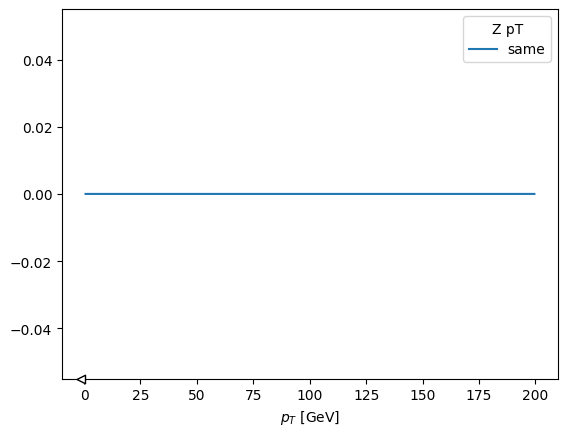

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
computed["GenPartZ"]["pt"].plot1d(ax=ax)
#ax.set_xscale("log")
ax.legend(title="Z pT")

In [8]:
fileset = {
    'GenPartZ': {
        "files": {
            'file://2022EE/Zto2Q-4Jets_HT-400to600.root': "Events",
        }
    },

}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

IndexError: cannot slice EmptyArray (of length 0) with ['file', 'object_path', 'steps', 'num_entries', 'uuid']: not an array of records

In [ ]:
to_compute = apply_to_fileset(
                MyProcessor(),
                max_chunks(dataset_runnable, 100),
                schemaclass=BaseSchema,
            )
(out,) = dask.compute(to_compute)
print(out)

{'GenPartZ': {'GenPartZ': {'entries': 103651, 'pt': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='pt', label='$p_{T}$ [GeV]'),
  storage=Int64())}}}


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


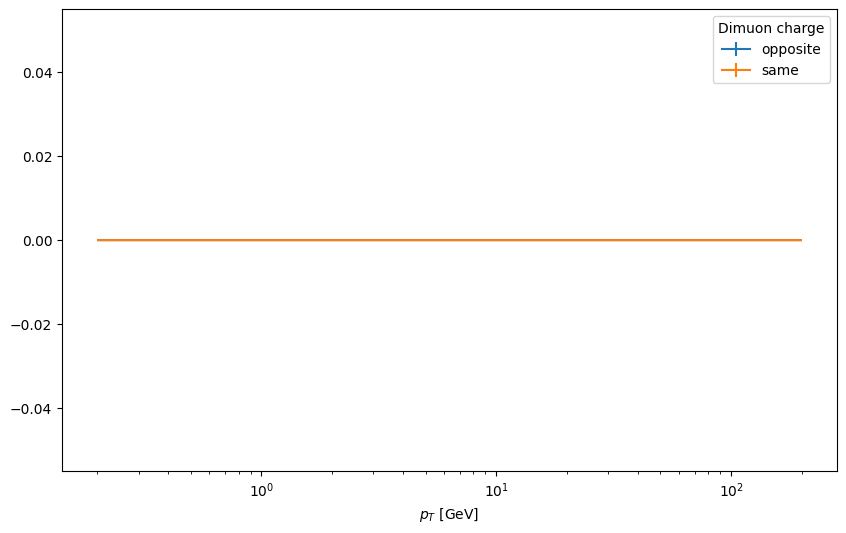

2024-06-26 22:36:42,519 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/distributed/worker.py", line 1251, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
out["GenPartZ"]["GenPartZ"]["pt"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")